In [1]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 'Raw' = 'gray70')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 60',
             'HSIC Lasso, B = 30', 'HSIC Lasso, B = 20',
             'HSIC Lasso, B = 15', 'HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS', 'Raw')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
m_palette <- c('1' = '#c7e9b4', '2' = '#7fcdbb', '3' = '#41b6c4', 
               '4' = '#1d91c0', '5' = '#225ea8', '10' = '#0c2c84')

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Supplementary figure 1

In [2]:
pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- summarize_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- summarize_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- summarize_benchmark('../results/asu/warpPIE10P_prediction.tsv')

prediction_img <- bind_rows(pixraw10P, warpAR10P, orlraws10P, warpPIE10P) %>%
    mutate(model = factor(model, levels = methods))

face_recognition <- prediction_img %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_img, model == 'Raw'), aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 1)

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

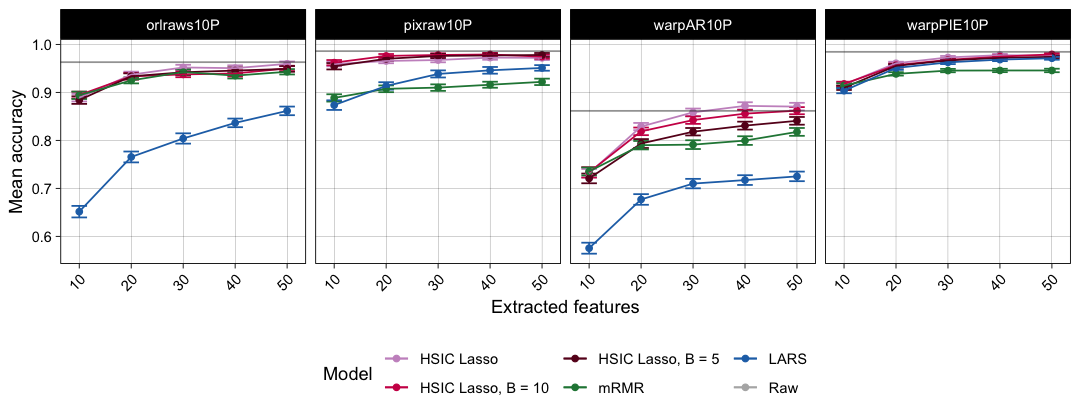

In [3]:
ggsave('img/supp_figure_1.pdf', face_recognition, width = 9, height = 3.5)
options(repr.plot.width = 9, repr.plot.height = 3.5)
face_recognition

# Supplementary figure 2

In [4]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist
   
}
                                     
parse_memory <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('MB', x)) {
            x <- gsub(' MB', '', x) %>% as.numeric
        } else if (grepl(' GB', x)) {
            x <- gsub(' GB', '', x) %>% as.numeric
            x <- x * 1000
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    lapply(column, parse_subfield) %>% unlist
   
}
                                     
read_trace <- function(tracefile) {
    
    read_tsv(tracefile, col_types = 'cccccccccccccc') %>%
        mutate(time_s = parse_deltatime(realtime),
               memory_mb = parse_memory(vmem),
               task = gsub(' .+', '', name) %>% gsub('run_', '', .) %>% toupper,
               causal = gsub('.+[^0-9] \\(', '', name) %>% gsub(',.+', '', .),
               B = gsub('.+ B = ', '', name) %>% gsub(',? .+', '', .),
               M = gsub('.+ M = ', '', name) %>% gsub(' .+', '', .)) %>% 
        filter(task %in% c('HSIC_LASSO', 'LARS', 'MRMR')) %>%
        mutate(task = ifelse(task == 'HSIC_LASSO', 'HSIC Lasso', task),
               task = ifelse(task == 'MRMR', 'mRMR', task),
               task = ifelse(task == 'HSIC Lasso' & B != '0', paste0(task, ', B = ', B), task),
               task = factor(task, levels = methods))
    
}

In [5]:
runtime <- read_trace('../results/benchmark/trace.txt')
memory <- read_trace('../results/resources/trace.txt')

runtime_plt <- ggplot(runtime, aes(x = task, y = time_s, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Time (s)', x = '') +
        scale_fill_manual(values = palette) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

memory_plt <- ggplot(memory, aes(x = task, y = memory_mb, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Memory (MB)', x = '') +
        scale_fill_manual(values = palette) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

accuracy_b_m <- read_tsv('../results/stability/random_feature_selection.tsv', 
                         col_types = 'ciiiiid') %>%
    mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           B = gsub('.+-B=', '', model),
           B = gsub('-M.+', '', B),
           M = gsub('.+-M=', '', model),
           model = gsub('-B.+', '', model)) %>%
    group_by(model, B, M, samples, features, causal) %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(model == 'HSIC Lasso') %>%
    mutate(B = as.integer(B),
           M = factor(M, levels = unique(sort(as.integer(M))))) %>%
    ggplot(aes(x = B, y = tpr, color = M)) +
        geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 1) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') + 
        labs(y = '% true features') +
        scale_x_continuous(breaks = c(5,10,15,30,60)) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = m_palette)

computations <- plot_grid(runtime_plt, memory_plt, accuracy_b_m, labels = c('A', 'B', 'C'), 
                          nrow = 2)

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

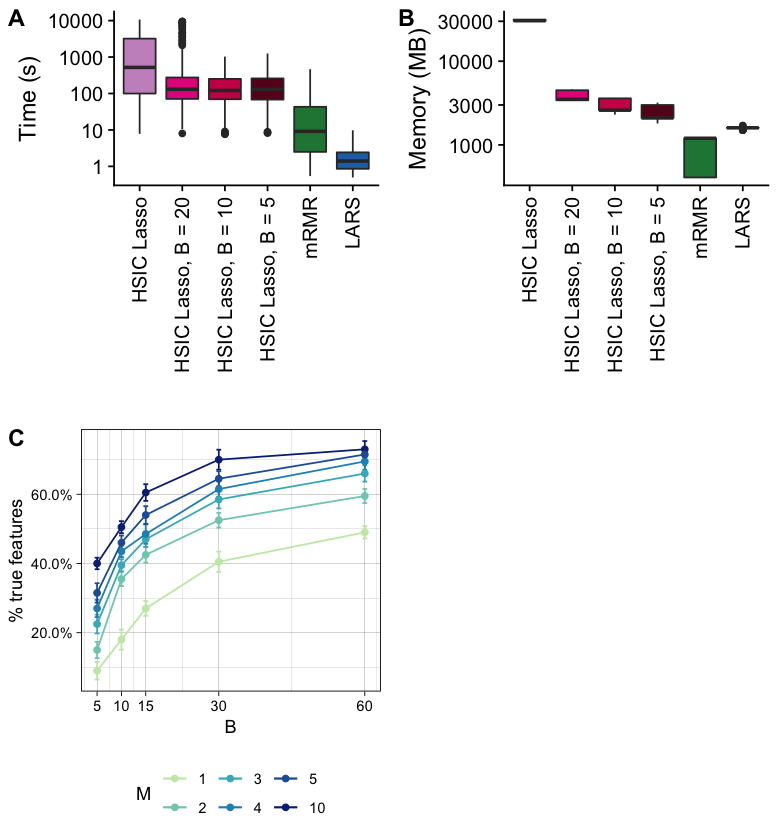

In [6]:
ggsave('img/supp_figure_2.pdf', computations, width = 6.5, height = 7)
options(repr.plot.width=6.5, repr.plot.height=7)
computations

# Supplementary figure 3

In [7]:
summarize_benchmark <- function(label) {
    
    read_tsv(paste0('../results/single_cell/', label, '_prediction.tsv'), col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
        ungroup %>%
        mutate(label = paste(tools::toTitleCase(label), 'et al.'))

}

sc <- bind_rows(summarize_benchmark('haber'), summarize_benchmark('habib'), summarize_benchmark('villani'))

raw <- filter(sc, model == 'Raw')
sc <- filter(sc, model != 'Raw')

sc <- ggplot(sc, aes(x = selected, y = accuracy, color = model)) +
    geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
    geom_point() +
    geom_line() +
    geom_hline(data = raw, aes(yintercept = accuracy), size = 0.7, 
               colour = 'gray20', alpha = 0.5) + 
    theme_linedraw() +
    theme(legend.position = 'bottom',
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
    scale_color_manual(values = palette) +
    facet_grid(. ~ label)

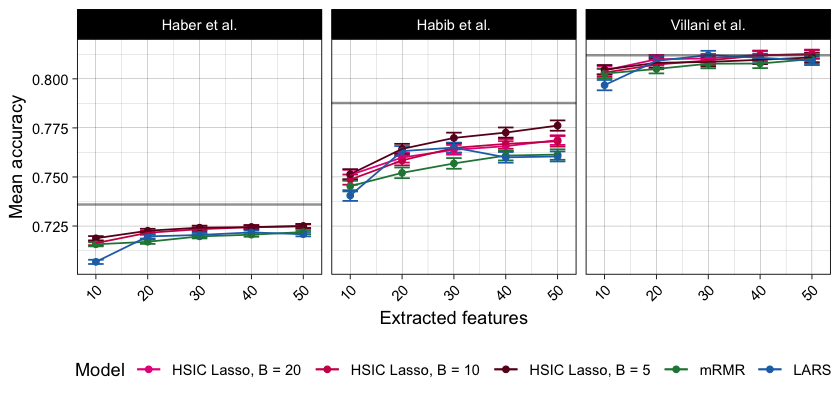

In [8]:
ggsave('img/supp_figure_3.pdf', sc, width = 7, height = 3.35)
options(repr.plot.width=7, repr.plot.height=3.35)
sc